# 1. Quantum machine learning, masters thesis source code.
Sources for original codes are:
* https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/63ef278c9730746362d08162a440df77/speech_command_classification_with_torchaudio_tutorial.ipynb
* https://github.com/huckiyang/QuantumSpeech-QCNN

# 2. Data preparation

In [ ]:
!pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

from tqdm import tqdm
from torchaudio.datasets import SPEECHCOMMANDS

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Prepare SpeechCommands dataset

In [ ]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))

# 4. Formatting of data.

In [ ]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

# 5. Encoding of data.

In [ ]:
import numpy as np

labels  = np.load('/datasets/new_labels.npy')
labels = labels.tolist()

def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))

def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

# 6. Quantum CNN

In [ ]:
!pip install pennylane
!pip install qiskit

import librosa
import librosa.display
import pandas as pd
import pennylane as qml
import qiskit
import seaborn as sn
import tensorflow as tf
import time as ti
import warnings
import random

from keras.utils.layer_utils import count_params
from pennylane import numpy as np
from pennylane.templates import RandomLayers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers  import Conv2D, MaxPooling2D, Dense, Flatten, GRU, BatchNormalization, Conv1D, Dropout, Bidirectional, MaxPooling1D, Input, Lambda, TimeDistributed, Activation
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.utils import set_random_seed
from tensorflow.math import confusion_matrix
from tensorflow.random import set_seed


## Local Definition 
#os.environ["CUDA_VISIBLE_DEVICES"]="1"


# 7. Limited dataset

In [ ]:
reduced_labels = ['left', 'go', 'yes', 'down', 'up', 'on', 'right', 'no', 'off', 'stop']

# 8. Mount Google drive to colab for saving the data

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# 9. LSTM Model

In [ ]:
def attrnn_Model(x_in, labels, ablation = False, params = 64, divider = 1):
    # simple LSTM
    rnn_func = L.LSTM
    # Restrict parameter amount
    use_Unet = True

    if len(x_in.shape) >= 3:
        h_feat,w_feat,ch_size = x_in.shape
        inputs = keras.layers.Input(shape=(h_feat, w_feat, ch_size))
    else:
        h_feat, w_feat = x_in.shape
        inputs = keras.layers.Input(shape=(h_feat, w_feat))

    inputs = L.Input(shape=(h_feat, w_feat, ch_size))

    if ablation == True:
        x = L.Conv2D(4, (1, 1), strides=(2, 2), activation='relu', padding='same', name='abla_conv')(inputs)
        x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)
    else:
        x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(inputs)

    # note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
    # we would rather have it the other way around for LSTMs
    x = L.Permute((2, 1, 3))(x)

    if use_Unet == True:
        x = L.Conv2D(16//divider, (5, 1), activation='relu', padding='same')(x)
        up = L.BatchNormalization()(x)
        x = L.Conv2D(32//divider, (5, 1), activation='relu', padding='same')(up)
        x = L.BatchNormalization()(x)
        x = L.Conv2D(16//divider, (5, 1), activation='relu', padding='same')(x)
        down = L.BatchNormalization()(x)
        merge = L.Concatenate(axis=3)([up,down])
        x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(merge)
        x = L.BatchNormalization()(x)
    else:
        x = L.Conv2D(10, (5, 1), activation='relu', padding='same')(x)
        x = L.BatchNormalization()(x)
        x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
        x = L.BatchNormalization()(x)

    x = L.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(x)
    # Classical model has significantly more parameters here
    x = L.Bidirectional(rnn_func(params//divider, return_sequences=True))(x)  # [b_s, seq_len, vec_dim]
    x = L.Bidirectional(rnn_func(64//divider, return_sequences=True))(x)  # [b_s, seq_len, vec_dim]

    xFirst = L.Lambda(lambda q: q[:, -1])(x)  # [b_s, vec_dim]
    query = L.Dense(128//divider)(xFirst)
    #query = L.Dense(126)(xFirst)

    # dot product attention
    attScores = L.Dot(axes=[1, 2])([query, x])
    attScores = L.Softmax(name='attSoftmax')(attScores)  # [b_s, seq_len]

    # rescale sequence
    attVector = L.Dot(axes=[1, 1])([attScores, x])  # [b_s, vec_dim]

    x = L.Dense(64//divider, activation='relu')(attVector)
    x = L.Dense(32//divider)(x)

    output = L.Dense(len(labels), activation='softmax', name='output')(x)

    model = Model(inputs=inputs, outputs=output, name='Attn-BiLSTM')
    model.compile(
        optimizer=SGD(learning_rate=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
        #optimizer=SGD(learning_rate=0.02, decay=1e-6, momentum=0.1, nesterov=True, clipnorm=5),
        loss="categorical_crossentropy",
        metrics=["accuracy"],)

    return model

# 10. Mel spectrogram generator

In [ ]:
def gen_mel(labels, train_audio_path, sr, port):
    all_wave = []
    all_label = []
    #Original values
    #win_size = 1024
    #hop = 128
    win_size = 400
    hop = 300
    for num, wav in enumerate(train_audio_path, 0):
        if num % port ==0:   # take 1/port samples
            # Test same sample ratio as in classical case
            if sr == 8000:
                audio_arr = np.array(transform(wav[0]))
            else:
                audio_arr = np.array(wav[0])
            
            shape = audio_arr.shape
            if(shape[1] == sr and wav[2] in labels):
                audio_arr = audio_arr.reshape(sr)
                mel_feat = librosa.feature.melspectrogram(audio_arr, sr=sr, n_fft=win_size, hop_length=hop, power=1.0, n_mels=60, fmin=40.0, fmax=sr/2)
                all_wave.append(np.expand_dims(mel_feat, axis=2))
                all_label.append(wav[2])
    #print(all_label)
    return all_wave, all_label

# 11. Quantum circuit and QCNN

In [ ]:
n_w = 4 # numbers of wires def 4
noise_mode = False # for running at QPU

if  noise_mode == True:
    dev = qml.device('qiskit.aer', wires= n_w, noise_model=noise_model)
else:
    dev = qml.device("default.qubit", wires= n_w)

n_layers = 1

# Random circuit parameters
#rand_params = np.random.uniform(high= 2 * np.pi, size=(n_layers, n_w)) # def 2, n_w = 4
rand_params = np.array([[3.48469964, 4.89657317, 3.11940734, 2.06955704]])

params = [[0.04439891,0.14490549,3.29725643],
          [2.51240058,0.29320901,6.11828637],
          [1.46254547,0.56929702,3.88543389],
          [2.40307956,6.17782186,2.93275775]]

@qml.qnode(dev)
def circuit(phi=None):
    # Encoding of 4 classical input values
    for j in range(n_w):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(n_w)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_w)]

@qml.qnode(dev)
def circuit2(phi):
    for j in range(n_w):
        qml.RY(np.arctan(phi[j]), wires=j)
        qml.RZ(np.arctan(phi[j]**2), wires=j)

    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,2])
    qml.CNOT(wires=[2,3])
    qml.CNOT(wires=[3,0])

    for j in range(n_w):
        x,y,z = params[j]
        qml.Rot(x,y,z, wires=j)
    
    return qml.expval(qml.PauliZ(0))
    
def quanv(image, kr):
    h_feat, w_feat, ch_n = image.shape
    """Convolves the input speech with many applications of the same quantum circuit."""
    out = np.zeros((h_feat//kr, w_feat//kr, n_w))

    # Loop over the coordinates of the top-left pixel of squares
    for j in range(1, h_feat, kr):
        for k in range(1, w_feat, kr):
            # Process a squared 3x3 region of the image with a quantum circuit
            if kr == 3:
                q_results = circuit(# kernel 3 
                    phi=[image[j, k, 0], image[j, k + 1, 0], image[j, k + 2, 0],
                         image[j + 1, k, 0], image[j + 1, k + 1, 0], image[j + 1, k +2 , 0],
                         image[j+2, k, 0], image[j+2, k+1, 0], image[j+2, k+2, 0]])
            # Process a squared 2x2 region of the image with a quantum circuit
            else:
                q_results = circuit(# Kernel 2
                    phi=[image[j-1, k-1, 0], image[j-1, k, 0],
                         image[j, k-1, 0], image[j, k, 0]])
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(n_w):
                out[j // kr, k // kr, c] = q_results[c]
    return out

def quanv2(image, kr):
    h_feat, w_feat, ch_n = image.shape
    """Convolves the input speech with many applications of the same quantum circuit."""
    out = np.zeros((h_feat//kr, w_feat//kr, ch_n))

    # Loop over the coordinates of the top-left pixel of squares
    for j in range(1, h_feat, kr):
        for k in range(1, w_feat, kr):
            # Process a squared 3x3 region of the image with a quantum circuit
            q_results = circuit2(
                phi=[image[j-1, k-1, 0], image[j-1, k, 0],
                      image[j, k-1, 0], image[j, k, 0]])
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            out[j // kr, k // kr, 0] = q_results 
            
    return out

def gen_qspeech(x_train, x_valid, kr): # kernal size = 2x2 or 3x3
    #q_train = []
    #q_train = np.load('/datasets/q_trainFULL_ALTKERN.npy')
    #q_train = np.load('/datasets/q_trainTIME_TEST.npy')
    q_train = np.load('/datasets/q_trainTIME_TEST_kernel2.npy')
    q_train = q_train.tolist()
    print("Quantum pre-processing of train Speech:")
    for idx, img in enumerate(x_train):
        print("\r{}/{}        ".format(idx + 1, len(x_train)),end='')
        #q_train.append(quanv(img, kr))
        q_train.append(quanv2(img, kr))
    
    q_train = np.asarray(q_train)
    
    #q_valid = np.load('/datasets/q_validFULL_ALTKERN.npy')
    #q_valid = np.load('/datasets/q_validTIME_TEST.npy')
    q_valid = np.load('/datasets/q_validTIME_TEST_kernel2.npy')
    q_valid = q_valid.tolist()
    #q_valid =[]
    print("\nQuantum pre-processing of test Speech:")
    for idx, img in enumerate(x_valid):
        print("\r{}/{}        ".format(idx + 1, len(x_valid)), end="")
        #q_valid.append(quanv(img, kr))
        q_valid.append(quanv2(img, kr))
    
    q_valid = np.asarray(q_valid)
    #np.save('/datasets/q_trainTIME_TEST.npy',q_train)
    #np.save('/datasets/q_validTIME_TEST.npy',q_valid)

    np.save('/datasets/q_trainTIME_TEST_kernel2.npy',q_train)
    np.save('/datasets/q_validTIME_TEST_kernel2.npy',q_valid)
    
    return q_train, q_valid

# 12. Original kernel

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


(<Figure size 576x360 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7ff5637fe2b0>)

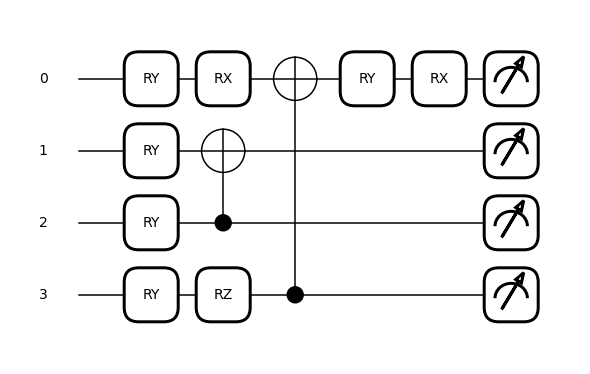

In [ ]:
qml.draw_mpl(circuit, expansion_strategy="device")(np.array([0,1,1,0]))

# 13. Alternative kernel

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7ff4ecdde9d0>)

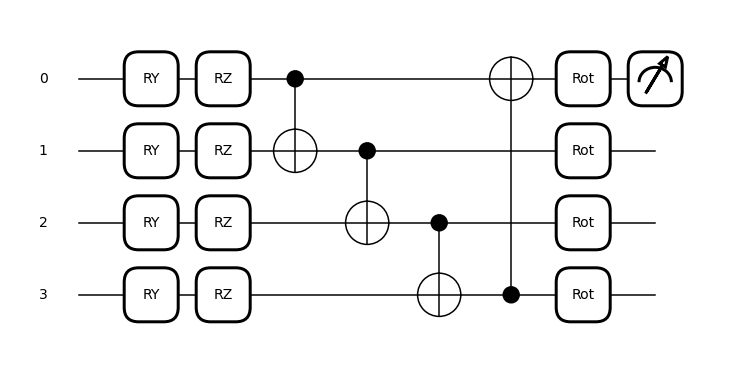

In [ ]:
qml.draw_mpl(circuit2, expansion_strategy="device")(np.array([0,1,1,0]))

# 14. Classical convolution

In [ ]:
def kernel(phi):
    # Classical kernel
    kern = [1,0,0,1]
    sum = 0;
    for i,j in zip(kern,phi):
        sum += i * j

    return sum

def conv(image, kr):
    h_feat, w_feat, ch_n = image.shape
    """Classic convolution"""
    out = np.zeros((h_feat//kr, w_feat//kr, ch_n))

    # Loop over the coordinates of the top-left pixel of squares
    for j in range(1, h_feat, kr):
        for k in range(1, w_feat, kr):
            result = kernel(
                phi=[image[j-1, k-1, 0], image[j-1, k, 0],
                      image[j, k-1, 0], image[j, k, 0]])
            # Assign expectation values to output pixel (j/2, k/2)
            out[j // kr, k // kr, 0] = result
            
    return out

def gen_speech(x_train, x_valid, kr):
    #c_train = np.load('/datasets/c_trainFULL.npy')
    c_train = np.load('/datasets/c_trainTIME_TEST.npy')
    c_train = c_train.tolist()
    #c_train = []
    print("Classical pre-processing of train Speech:")
    for idx, img in enumerate(x_train):
        print("\r{}/{}        ".format(idx + 1, len(x_train)),end='')
        c_train.append(conv(img, kr))
    
    c_train = np.asarray(c_train)
    
    #c_valid = np.load('/datasets/c_validFULL.npy')
    c_valid = np.load('/datasets/c_validTIME_TEST.npy')
    c_valid = c_valid.tolist()
    #c_valid =[]
    print("\nClassical pre-processing of test Speech:")
    for idx, img in enumerate(x_valid):
        print("\r{}/{}        ".format(idx + 1, len(x_valid)), end="")
        c_valid.append(conv(img, kr))
    
    c_valid = np.asarray(c_valid)
    
    np.save('/datasets/c_trainTIME_TEST.npy',c_train)
    np.save('/datasets/c_validTIME_TEST.npy',c_valid)

    return c_train, c_valid

# 15. Data preparation

In [ ]:
START = 0
END = 10
SR = 16000
# take 1/port samples
PORT = 1
kr = 2
# Change kr to 1 to tests affect of stride 1
#kr = 1

def gen_train(labels, train_audio_path, sr, port):
    all_wave, all_label = gen_mel(labels, train_audio_path, sr, port)

    label_enconder = LabelEncoder()
    y = label_enconder.fit_transform(all_label)
    classes = list(label_enconder.classes_)
    y = keras.utils.to_categorical(y, num_classes=len(labels))

    x_train, x_valid, y_train, y_valid = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)
    h_feat, w_feat, _ = x_train[0].shape
    
    print("===== Shape", h_feat, w_feat)

    return x_train, x_valid, y_train, y_valid

def gen_quanv(x_train, x_valid, kr):
    print("Kernel = ", kr)
    q_train, q_valid = gen_qspeech(x_train, x_valid, kr)

    return q_train, q_valid

def gen_conv(x_train, x_valid, kr):
    print("Kernel = ", kr)
    c_train, c_valid = gen_speech(x_train, x_valid, kr)

    return c_train, c_valid

def save_mel(x_train, x_valid, y_train, y_valid):
    np.save('/datasets/x_train.npy',x_train)
    np.save('/datasets/x_valid.npy',x_valid)
    np.save('/datasets/y_train.npy',y_train)
    np.save('/datasets/y_valid.npy',y_valid)

def load_mel():
    x_train = np.load('/datasets/equal_x_train.npy')
    x_valid = np.load('/datasets/equal_x_valid.npy')
    y_train = np.load('/datasets/equal_y_train.npy')
    y_valid = np.load('/datasets/equal_y_valid.npy')

    return x_train, x_valid, y_train, y_valid

def load_mel_FULL():
    x_train = np.load('/datasets/x_trainFULL.npy')
    x_valid = np.load('/datasets/x_validFULL.npy')
    y_train = np.load('/datasets/y_trainFULL.npy')
    y_valid = np.load('/datasets/y_validFULL.npy')

    return x_train, x_valid, y_train, y_valid

def load_quanv():
    q_train = np.load('/datasets/equal_q_train.npy')
    q_valid = np.load('/datasets/equal_q_valid.npy')

    return q_train, q_valid

def load_quanv_FULL():
    q_train = np.load('/datasets/q_trainFULL_ALTKERN.npy')
    q_valid = np.load('/datasets/q_validFULL_ALTKERN.npy')

    return q_train, q_valid

def load_conv():
    c_train = np.load('/datasets/c_trainFULL.npy')
    c_valid = np.load('/datasets/c_validFULL.npy')

    return c_train, c_valid

#dataset = train_set+test_set
#x_train, x_valid, y_train, y_valid = gen_train(labels, dataset, SR, PORT)
#save_mel(x_train, x_valid, y_train, y_valid)
x_train, x_valid, y_train, y_valid = load_mel_FULL()
#print(x_train.shape,x_valid.shape,y_train.shape,y_valid.shape)
#q_train, q_valid = load_quanv_FULL()
#c_train, c_valid = load_conv()
#equal_q_train, equal_q_valid = load_quanv()

#START = q_valid.shape[0]
#END = START+10

c_train = []
c_valid = []
c_train = np.asarray(c_train)
c_valid = np.asarray(c_valid)
np.save('/datasets/c_trainTIME_TEST.npy',c_train)
np.save('/datasets/c_validTIME_TEST.npy',c_valid)
print(c_train.shape,c_valid.shape)

'''
q_train = []
q_valid = []
q_train = np.asarray(q_train)
q_valid = np.asarray(q_valid)
#np.save('/datasets/q_trainTIME_TEST.npy',q_train)
#np.save('/datasets/q_validTIME_TEST.npy',q_valid)
np.save('/datasets/q_trainTIME_TEST_kernel2.npy',q_train)
np.save('/datasets/q_validTIME_TEST_kernel2.npy',q_valid)
print(q_train.shape,q_valid.shape)
'''

start = ti.time()

while(END<=50):
    #q_train, q_valid = gen_quanv(x_train[START:END,:,:,:], x_valid[START:END,:,:,:], kr)
    c_train, c_valid = gen_conv(x_train[START:END,:,:,:], x_valid[START:END,:,:,:], kr)
    print()
    #print(q_train.shape,q_valid.shape)
    print(c_train.shape,c_valid.shape)
    #START = q_valid.shape[0]
    START = c_train.shape[0]
    END = START+10
    #END = 10001

spent = ti.time() - start
print('time spent',spent)

# 16. Functions to load premade datasets

In [ ]:
import numpy as np

# Datasets with full Mel spectrogram window
def time_tests():
    x_train = np.load('/datasets/x_trainFULL.npy')
    x_valid = np.load('/datasets/x_validFULL.npy')
    c_train = np.load('/datasets/c_trainTIME_TEST.npy')
    c_valid = np.load('/datasets/c_validTIME_TEST.npy')
    q_train = np.load('/datasets/q_trainTIME_TEST.npy')
    q_valid = np.load('/datasets/q_validTIME_TEST.npy')
    q_train2 = np.load('/datasets/q_trainTIME_TEST_kernel2.npy')
    q_valid2 = np.load('/datasets/q_validTIME_TEST_kernel2.npy')
    y_train = np.load('/datasets/y_trainFULL.npy')
    y_valid = np.load('/datasets/y_validFULL.npy')

    return x_train[0:50,:,:,:],x_valid[0:50,:,:,:],c_train,c_valid,q_train,q_valid,q_train2,q_valid2,y_train[0:50,:],y_valid[0:50,:]

def reduced():
    x_train = np.load('/datasets/x_trainREDUCED.npy')
    x_valid = np.load('/datasets/x_validREDUCED.npy')
    q_train = np.load('/datasets/q_trainREDUCED.npy')
    q_valid = np.load('/datasets/q_validREDUCED.npy')
    y_train = np.load('/datasets/y_trainREDUCED.npy')
    y_valid = np.load('/datasets/y_validREDUCED.npy')

    return x_train,x_valid,q_train,q_valid,y_train,y_valid

def full_window():
    x_train = np.load('/datasets/x_trainFULL.npy')
    x_valid = np.load('/datasets/x_validFULL.npy')
    q_train = np.load('/datasets/q_trainFULL.npy')
    q_valid = np.load('/datasets/q_validFULL.npy')
    y_train = np.load('/datasets/y_trainFULL.npy')
    y_valid = np.load('/datasets/y_validFULL.npy')

    return x_train,x_valid,q_train,q_valid,y_train,y_valid


# Datasets with smaller Mel spectrogram window
def smaller_window():
    q_train = np.load('/datasets/q_train.npy')
    q_valid = np.load('/datasets/q_valid.npy')
    x_train = np.load('/datasets/x_train.npy')
    x_valid = np.load('/datasets/x_valid.npy')
    y_train = np.load('/datasets/y_train.npy')
    y_valid = np.load('/datasets/y_valid.npy')

    return x_train,x_valid,q_train,q_valid,y_train,y_valid


# Datasets with equalized distribution. 134 samples / class
def equalized():
    equal_q_train = np.load('/datasets/equal_q_train.npy')
    equal_q_valid = np.load('/datasets/equal_q_valid.npy')
    equal_x_train = np.load('/datasets/equal_x_train.npy')
    equal_x_valid = np.load('/datasets/equal_x_valid.npy')
    equal_y_train = np.load('/datasets/equal_y_train.npy')
    equal_y_valid = np.load('/datasets/equal_y_valid.npy')

    return equal_x_train,equal_x_valid,equal_q_train,equal_q_valid,equal_y_train,equal_y_valid

# Datasets with classical convolution
def classic_conv():
    c_train = np.load('/datasets/c_train.npy')
    c_valid = np.load('/datasets/c_valid.npy')
    q_train = np.load('/datasets/q_trainFULL_ALTKERN.npy')
    q_valid = np.load('/datasets/q_validFULL_ALTKERN.npy')
    y_train = np.load('/datasets/y_trainFULL.npy')
    y_valid = np.load('/datasets/y_validFULL.npy')

    return c_train,c_valid,q_train,q_valid,y_train,y_valid

#x_train,x_valid,q_train,q_valid,y_train,y_valid = full_window()
#x_train,x_valid,q_train,q_valid,y_train,y_valid = classic_conv()
#x_train,x_valid,q_train,q_valid,y_train,y_valid = smaller_window()
#x_train,x_valid,q_train,q_valid,y_train,y_valid = equalized()
#x_train,x_valid,c_train,c_valid,q_train,q_valid,q_train2,q_valid2,y_train,y_valid = time_tests()
x_train,x_valid,q_train,q_valid,y_train,y_valid = reduced()


# 17. Function to reduce number of classes

In [ ]:
def reduce_labels(xs,qs,ys,to_drop):
    new_x=[]
    new_q=[]
    new_y=[]
    to_keep = []
    for name in labels:
        if name not in to_drop:
            idx = label_to_index(name)
            to_keep.append(idx)
    for x,q,y in zip(xs,qs,ys):
        idx = np.where(y == 1)
        name = index_to_label(idx[0][0])
        if name not in to_drop:
            new_x.append(x)
            new_q.append(q)
            new_y.append(y)
        
    new_y = np.array(new_y)
    new_y = new_y[:,to_keep]
    return np.array(new_x),np.array(new_q),new_y

# 18. Print label distribution

In [ ]:
print(len(labels))
print(labels)
print(np.sum(y_train,axis=0))
print(np.sum(y_valid,axis=0))

# 19. Reduce number of datapoints to make equally distributed dataset

In [ ]:
amount = 134
x_train, q_train, y_train = reduce_data(x_train, q_train, y_train, amount)
x_valid, q_valid, y_valid = reduce_data(x_valid, q_valid, y_valid, amount)

# 20. Training function

In [ ]:
def fit_model(model,trainx,trainy,valx,valy,check):
    history = model.fit(
        x=trainx, 
        y=trainy[0:trainx.shape[0],:],
        epochs=EPOCHS, 
        callbacks=[check], 
        batch_size=BATCH_SIZE, 
        validation_data=(valx,valy[0:valx.shape[0],:])
    )

    return history

## For Quanv Exp.
early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                           verbose=1, patience=10, min_delta=0.0001)

checkpoint = ModelCheckpoint('/some_models/best_classic_reduced.hdf5', monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')

qcnn_checkpoint = ModelCheckpoint('/some_models/best_qcnn_reduced.hdf5', monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')
'''
qcnn_kernel2_checkpoint = ModelCheckpoint('/some_models/best_qcnn_kernel2_time_test.hdf5', monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')

conv_checkpoint = ModelCheckpoint('/some_models/best_conv_time_test.hdf5', monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')
'''

# 21. Make results persistent

In [ ]:
seed = 1337       #0.9236871004104614 / 0.9225929975509644
#seed = 42        #0.9280634522438049 / 0.8864879608154297
#seed = 70770     #92.7 / 91.3
#seed = 70110     #89.6 / 90.2
#seed = 7734      #0.916301965713501 / 0.937089741230011
#seed = 1234      #93.5 / 90.8
#seed = 4321      #94.3 / 92.5
#seed = 2022      #93.3 / 89.7
#seed = 4851      #0.9149343371391296 / 0.908369779586792
#seed = 6817      #0.9070022106170654 / 0.912472665309906
#seed = 2580      #0.9368162155151367 / 0.9239606261253357
#seed = 9630      #0.8998906016349792 / 0.9217724204063416
#seed = 777       #0.9376367330551147 / 0.9171225428581238
#seed = 9154      #0.9392778873443604 / 0.908369779586792
#seed = 1         #0.9373632669448853 / 0.9141137599945068
#seed = 9999      #0.9261487722396851 / 0.886761486530304
#seed = 6161      #0.9318927526473999 / 0.8894967436790466
#seed = 8723654   #0.9138402342796326 / 0.8998906016349792
#seed = 6548      #0.9275164008140564 / 0.9119256138801575
#seed = 43        #0.9321662783622742 / 0.9031728506088257
#seed = 3310      #0.925328254699707 / 0.9132932424545288
#seed = 315       #0.904540479183197 / 0.9018052220344543
#seed = 78857676  #0.9217724204063416 / 0.9165754914283752

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
set_random_seed(seed)
set_seed(seed)

#22. Training of normal models

In [ ]:
print('Dataset sizes: ',q_train.shape, q_valid.shape)

EPOCHS = 30
BATCH_SIZE = 16

model = attrnn_Model(x_train[0], y_train[0], False, 64, 1)
model.summary()
classic_hist = fit_model(model,x_train[0:q_train.shape[0],:,:,:],y_train[0:q_train.shape[0],:],x_valid[0:q_valid.shape[0],:,:,:],y_valid[0:q_valid.shape[0],:],checkpoint)

model = attrnn_Model(q_train[0], y_train[0], False, 64, 1)
model.summary()
qcnn_hist = fit_model(model,q_train,y_train,q_valid,y_valid,qcnn_checkpoint)


#np.save('/training_histories/classic_histFULL.npy', classic_hist.history)     #OK
#np.save('/training_histories/qcnn_histFULL_ALTKERN.npy', qcnn_hist.history)   #OK
#np.save('/training_histories/cconv_histFULL.npy', classic_hist.history)       #OK
#np.save('/training_histories/qcnn_histFULL.npy', qcnn_hist.history)           #OK
#np.save('/training_histories/classic_hist.npy', classic_hist.history)         #OK
#np.save('/training_histories/qcnn_hist.npy', qcnn_hist.history)               #OK
#np.save('/training_histories/cconv_hist.npy', classic_hist.history)           #OK
#np.save('/training_histories/classic_histTENCLASS.npy', classic_hist.history) #OK
#np.save('/training_histories/qcnn_histTENCLASS.npy', qcnn_hist.history)       #OK

# 23. Timing of models

In [ ]:
print('Dataset sizes: ',q_train.shape, q_valid.shape)

EPOCHS = 30
BATCH_SIZE = 16
times = []
start = ti.time()

model = attrnn_Model(x_train[0], labels, False, 64, 1)
model.summary()
classic_hist = fit_model(model,x_train,y_train,x_valid,y_valid,checkpoint)
times.append(ti.time() - start)

start = ti.time()
model = attrnn_Model(q_train[0], labels, False, 64, 1)
model.summary()
qcnn_hist = fit_model(model,q_train,y_train,q_valid,y_valid,qcnn_checkpoint)
times.append(ti.time() - start)

start = ti.time()
model = attrnn_Model(q_train2[0], labels, False, 64, 1)
model.summary()
qcnn2_hist = fit_model(model,q_train2,y_train,q_valid2,y_valid,qcnn_kernel2_checkpoint)
times.append(ti.time() - start)

start = ti.time()
model = attrnn_Model(c_train[0], labels, False, 64, 1)
model.summary()
conv_hist = fit_model(model,c_train,y_train,c_valid,y_valid,conv_checkpoint)
times.append(ti.time() - start)

print(times)
np.save('/training_histories/classic_hist_timed.npy', classic_hist.history)               #OK
np.save('/training_histories/qcnn_hist_timed.npy', qcnn_hist.history)           #OK
np.save('/training_histories/qcnn2_hist_timed.npy', qcnn2_hist.history) #OK
np.save('/training_histories/conv_hist_timed.npy', conv_hist.history)       #OK

In [ ]:
classic_model = load_model('/some_models/best_classic_time_test.hdf5')
qcnn_model = load_model('/some_models/best_qcnn_time_test.hdf5')
qcnn2_model = load_model('/some_models/best_qcnn_kernel2_time_test.hdf5')
conv_model = load_model('/some_models/best_conv_time_test.hdf5')

times = []
start = ti.time()
classic_predict = classic_model.predict(x_valid,16)
times.append(ti.time() - start)

start = ti.time()
qcnn_predict = qcnn_model.predict(q_valid,16)
times.append(ti.time() - start)

start = ti.time()
qcnn2_predict = qcnn2_model.predict(q_valid2,16)
times.append(ti.time() - start)

start = ti.time()
conv_predict = conv_model.predict(c_valid,16)
times.append(ti.time() - start)

print(times)

# 24. Create confusion matrix

In [ ]:
def conf(yarr,predarr):
    conf_matrix = [[0 for i in range(yarr.shape[1])] for j in range(predarr.shape[1])]
    for y,pred in zip(yarr,predarr):
        max_y = max(y)
        max_pred = max(pred)
        idx_y = np.where(y == max_y)[0][0]
        idx_pred = np.where(pred == max_pred)[0][0]
        conf_matrix[idx_y][idx_pred] += 1
    
    return conf_matrix    

def get_predictions(model,data):
    predict = model.predict(data,16)
    
    return predict
    
def get_df(matrix, labels):
    df = pd.DataFrame(matrix, index = [i for i in labels],columns = [i for i in labels])
    
    return df

def plot_heatmap(df,title):
    plt.figure(figsize = (20,10))
    sn.heatmap(df, annot=True, fmt='g')
    plt.title(title)
    plt.show()

classic_model = load_model('/some_models/best_classic_reduced.hdf5')
qcnn_model = load_model('/some_models/best_qcnn_reduced.hdf5')

classic_predict = get_predictions(classic_model,x_valid)
qcnn_predict = get_predictions(qcnn_model,q_valid)

classic_conf_matrix = conf(y_valid,classic_predict)
qcnn_conf_matrix = conf(y_valid,qcnn_predict)

df_classic = get_df(classic_conf_matrix,labels)
df_qcnn = get_df(qcnn_conf_matrix,labels)

print(classic_conf_matrix)
print(qcnn_conf_matrix)


In [ ]:
plot_heatmap(df_classic,'Classic')

In [ ]:
plot_heatmap(df_qcnn,'Quanvolved')

In [ ]:
diagonal = np.diag(classic_conf_matrix)
qdiagonal = np.diag(qcnn_conf_matrix)

column_sums = np.sum(classic_conf_matrix, axis=0)
row_sums = np.sum(classic_conf_matrix, axis=1)
qcolumn_sums = np.sum(qcnn_conf_matrix, axis=0)
qrow_sums = np.sum(qcnn_conf_matrix, axis=1)

column_sums -= diagonal
row_sums -= diagonal
qcolumn_sums -= qdiagonal
qrow_sums -= qdiagonal

print('Classic false positive',column_sums,sum(column_sums))
print('Quantum false positive',qcolumn_sums,sum(qcolumn_sums))
print('Combined false positives',column_sums+qcolumn_sums)

cerrors = column_sums+row_sums
ctotal = column_sums+row_sums+diagonal
qerrors = qcolumn_sums+qrow_sums
qtotal = qcolumn_sums+qrow_sums+qdiagonal

total_errors = (cerrors+qerrors) / (cerrors+qerrors+ctotal+qtotal)
min_error = min(total_errors)
min_id = np.where(total_errors == min_error)[0][0]

to_drop = [labels[min_id]]
new_labels = []
for lbl in labels:
  if lbl not in to_drop:
    new_labels.append(lbl)

new_labels = np.array(new_labels)
np.save('/datasets/new_labels', new_labels)


x_train, q_train, y_train = reduce_labels(x_train, q_train, y_train, to_drop)
x_valid, q_valid, y_valid = reduce_labels(x_valid, q_valid, y_valid, to_drop)

np.save('/datasets/x_trainREDUCED.npy', x_train)
np.save('/datasets/x_validREDUCED.npy', x_valid)
np.save('/datasets/q_trainREDUCED.npy', q_train)
np.save('/datasets/q_validREDUCED.npy', q_valid)
np.save('/datasets/y_trainREDUCED.npy', y_train)
np.save('/datasets/y_validREDUCED.npy', y_valid)

In [ ]:
print(to_drop)

In [ ]:
save = {}
commands = len(labels)
save['commands'] = commands
save['classic_max'] = max(classic_hist.history['val_accuracy'])
save['qcnn_max'] = max(qcnn_hist.history['val_accuracy'])
save[f'classic_{commands}'] = classic_conf_matrix
save[f'qcnn_{commands}'] = qcnn_conf_matrix
save['to_drop'] = to_drop
np.save(f'/label_reduce_results/{commands}_tot_err.npy', save)

# 25. Plot normal model training loss and accuracy

In [ ]:
#Load saved training histories
import numpy as np
classic_hist = np.load('/datasets/classic_histTENCLASS.npy',allow_pickle='TRUE').item()
qcnn_hist = np.load('/datasets/qcnn_histTENCLASS.npy',allow_pickle='TRUE').item()

In [ ]:
data_ix = ti.strftime("%m%d_%H%M")
linestyle_arr = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 5, 1, 5, 1, 5))]

def plot_acc_loss(points, x_history, q_history, data_ix, x_label, q_label):
    plt.figure()
    plt.style.use("seaborn")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

    ax1.plot(q_history["val_accuracy"], linestyle=linestyle_arr[0], linewidth=1.5, color='b', label=q_label)
    ax1.plot(x_history["val_accuracy"], linestyle=linestyle_arr[1], linewidth=1.5, color='g', label=x_label)
    ax1.set_ylabel("Accuracy")
    ax1.set_ylim([0, 1])
    ax1.set_xlabel("Epoch")
    ax1.legend()

    ax2.plot(q_history["val_loss"], linestyle=linestyle_arr[0], linewidth=1.5, color='b', label=q_label)
    ax2.plot(x_history["val_loss"], linestyle=linestyle_arr[1], linewidth=1.5, color='g', label=x_label)
    ax2.set_ylabel("Loss")
    ax2.set_xlabel("Epoch")
    ax2.legend()
    plt.title('Number of datapoints: '+str(points))
    plt.tight_layout()
    plt.savefig("/Old_plots/"+ data_ix +"_conv_speech_loss.png")

def show_speech(x_train, q_train, use_ch):
    plt.figure()
    plt.subplot(5, 1, 1)
    if use_ch != True:
        librosa.display.specshow(librosa.power_to_db(x_train[7088,:,:,0], ref=np.max))
    else:
        librosa.display.specshow(librosa.power_to_db(x_train[0,:,:], ref=np.max))
    plt.title('Input Speech')

    for i in range(4):
        plt.subplot(5, 1, i+2)
        librosa.display.specshow(librosa.power_to_db(q_train[7088,:,:,i], ref=np.max))
        plt.title('Channel '+str(i+1)+': Quantum Compressed Speech')

    plt.tight_layout()
    plt.savefig("/Old_plots/speech_encoder_" + data_ix + ".png")

# Set legends for plot
x_label = "Attn-BiLSTM without Quanv Layer"
q_label = "Attn-BiLSTM with Quanv Layer"

plot_acc_loss(10000,classic_hist.history, qcnn_hist.history, data_ix, x_label, q_label)
#show_speech(x_train,q_train, False)

# 26. Print max and mean validation accuracies

In [ ]:
from scipy import stats
print('Max acc classic:',np.max(classic_hist.history["val_accuracy"]))
print('Avg acc classic:',np.average(classic_hist.history["val_accuracy"]))
print('Standard error of the mean:',stats.sem(classic_hist.history["val_accuracy"]))
print('Max acc quantum:',np.max(qcnn_hist.history["val_accuracy"]))
print('Avg acc quantum:',np.average(qcnn_hist.history["val_accuracy"]))
print('Standard error of the mean:',stats.sem(qcnn_hist.history["val_accuracy"]))

# 27. Function to reduce data points

In [ ]:
def reduce_data(x,q,y,to_amount):
    label_dict = {'backward':0, 'bed':0, 'bird':0, 'cat':0, 'dog':0, 'down':0, 'eight':0, 'five':0, 'follow':0, 'forward':0, 'four':0, 'go':0, 'happy':0, 'house':0, 'learn':0, 'left':0, 'marvin':0, 'nine':0, 'no':0, 'off':0, 'on':0, 'one':0, 'right':0, 'seven':0, 'sheila':0, 'six':0, 'stop':0, 'three':0, 'tree':0, 'two':0, 'up':0, 'visual':0, 'wow':0, 'yes':0, 'zero':0}
    ret_x = []
    ret_q = []
    ret_y = []
    for classic, quantum, lbl in zip(x,q,y):
      idx = np.where(lbl == 1)
      name = index_to_label(idx[0][0])
      amount = label_dict[name]
      if amount < to_amount:
        ret_x.append(classic)
        ret_q.append(quantum)
        ret_y.append(lbl)
        label_dict[name] += 1

    return np.array(ret_x), np.array(ret_q), np.array(ret_y)

# 28. Equalize dataset and introduce some helper variables

In [ ]:
x_train = x_train[0:q_train.shape[0],:,:,:]
y_train = y_train[0:q_train.shape[0],:]
x_valid = x_valid[0:q_valid.shape[0],:,:,:]
y_valid = y_valid[0:q_valid.shape[0],:]
ind = 0
EPOCHS = 30
BATCH_SIZE = 16

# 29. Training models with reduced datapoints

In [ ]:
amount = 22
div = 1
xtrain, qtrain, ytrain = reduce_data(x_train, q_train, y_train, amount)

model = attrnn_Model(xtrain[0], labels, False, 64, div)
classic_hist = fit_model(model,xtrain,ytrain,x_valid,y_valid,checkpoint).history

model = attrnn_Model(qtrain[0], labels, False, 64, div)
qcnn_hist = fit_model(model,qtrain,ytrain,q_valid,y_valid,qcnn_checkpoint).history

np.save(f"/datasets/classic_hist_{amount}_DATA_REDUCE_FULL.npy", classic_hist)
np.save(f"/datasets/qcnn_hist_{amount}_DATA_REDUCE_FULL.npy", qcnn_hist)

# 30. Plotting results from data reduced model

In [ ]:
data_ix = ti.strftime("%m%d_%H%M")
linestyle_arr = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 5, 1, 5, 1, 5))]
color = ['b','g','r','c','m','y','k']

def plot_acc_loss(points, x_history_arr, q_history_arr, data_ix, x_label, q_label):
    plt.figure()
    plt.style.use("seaborn")
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 9))

    for x_history, q_history, data, linestyle,col in zip(x_history_arr, q_history_arr, points, linestyle_arr,color):
        ax1.plot(x_history["val_accuracy"], linestyle=linestyle, linewidth=1.5, color=col, label='Number of datapoints '+str(data))
        ax1.set_title(x_label)
        ax1.set_ylabel("Accuracy")
        ax1.set_ylim([0, 1])
        ax1.set_xlabel("Epoch")
        ax1.legend()
        
        ax2.plot(q_history["val_accuracy"], linestyle=linestyle, linewidth=1.5, color=col, label='Number of datapoints '+str(data))
        ax2.set_title(q_label)
        ax2.set_ylabel("Accuracy")
        ax2.set_ylim([0, 1])
        ax2.set_xlabel("Epoch")
        ax2.legend()

        ax3.plot(x_history["val_loss"], linestyle=linestyle, linewidth=1.5, color=col, label='Number of datapoints '+str(data))
        ax3.set_ylabel("Loss")
        ax3.set_ylim([0, 8])
        ax3.set_xlabel("Epoch")
        ax3.legend()
        
        ax4.plot(q_history["val_loss"], linestyle=linestyle, linewidth=1.5, color=col, label='Number of datapoints '+str(data))
        ax4.set_ylabel("Loss")
        ax4.set_ylim([0, 8])
        ax4.set_xlabel("Epoch")
        ax4.legend()

    plt.title('Training models and reducing number of datapoints')
    plt.tight_layout()
    plt.savefig("/Old_plots/"+ data_ix +"_conv_speech_loss.png")

x_label = "Attn-BiLSTM without Quanv Layer"
q_label = "Attn-BiLSTM with Quanv Layer"

plot_acc_loss(data_size, classic_hist_arr, qcnn_hist_arr, data_ix, x_label, q_label)

# 31. Train models while reducing model parameters

In [ ]:
div_arr = [2,4,8,12,16]
div = 16

model = attrnn_Model(x_train[0], labels, False, 47, div)
model.summary()

classic_hist = fit_model(model,x_train,y_train,x_valid,y_valid,checkpoint).history
classic_weights = count_params(model.trainable_weights)

model = attrnn_Model(q_train[0], labels, False, 64, div)
model.summary()

qcnn_hist = fit_model(model,q_train,y_train,q_valid,y_valid,qcnn_checkpoint).history
qcnn_weights = count_params(model.trainable_weights)

np.save(f"/datasets/classic_hist_{classic_weights}_PARAM_REDUCE_FULL.npy", classic_hist)
np.save(f"/datasets/qcnn_hist_{qcnn_weights}_PARAM_REDUCE_FULL.npy", qcnn_hist)

# 32. Plotting data from parameter reduced model

In [ ]:
data_ix = ti.strftime("%m%d_%H%M")
linestyle_arr = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 5, 1, 5, 1, 5)))]
color = ['b','g','r','c','m','y','k']
def plot_acc_loss(cpoints, qpoints, x_history_arr, q_history_arr, data_ix, x_label, q_label):
    plt.figure()
    plt.style.use("seaborn")
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 9))

    for x_history, q_history, c_data, q_data, linestyle,col in zip(x_history_arr, q_history_arr, cpoints, qpoints, linestyle_arr,color):
        ax1.plot(x_history.history["val_accuracy"], linestyle=linestyle, linewidth=1.5, color=col, label='Number of parameters '+str(c_data))
        ax1.set_title(x_label)
        ax1.set_ylabel("Accuracy")
        ax1.set_ylim([0, 1])
        ax1.set_xlabel("Epoch")
        ax1.legend()
        
        ax2.plot(q_history.history["val_accuracy"], linestyle=linestyle, linewidth=1.5, color=col, label='Number of parameters '+str(q_data))
        ax2.set_title(q_label)
        ax2.set_ylabel("Accuracy")
        ax2.set_ylim([0, 1])
        ax2.set_xlabel("Epoch")
        ax2.legend()

        ax3.plot(x_history.history["val_loss"], linestyle=linestyle, linewidth=1.5, color=col, label='Number of parameters '+str(c_data))
        ax3.set_ylabel("Loss")
        ax3.set_ylim([0, 8])
        ax3.set_xlabel("Epoch")
        ax3.legend()
        
        ax4.plot(q_history.history["val_loss"], linestyle=linestyle, linewidth=1.5, color=col, label='Number of parameters '+str(q_data))
        ax4.set_ylabel("Loss")
        ax4.set_ylim([0, 8])
        ax4.set_xlabel("Epoch")
        ax4.legend()

    plt.title('Training models and reducing number of parameters')
    plt.tight_layout()
    plt.savefig("/Old_plots/"+ data_ix +"_conv_speech_loss.png")

x_label = "Attn-BiLSTM without Quanv Layer"
q_label = "Attn-BiLSTM with Quanv Layer"

plot_acc_loss(c_num_param, q_num_param, classic_hist_arr, qcnn_hist_arr, data_ix, x_label, q_label)

# 33. Print max and mean validation accuracies for data and parameter reduced models

In [ ]:
for classic,quantum in zip(classic_hist_arr,qcnn_hist_arr):
    print('Max acc classic:',np.max(classic["val_accuracy"]))
    print('Avg acc classic:',np.average(classic["val_accuracy"]))
    print('Max acc quantum:',np.max(quantum["val_accuracy"]))
    print('Avg acc quantum:',np.average(quantum["val_accuracy"]))

#34. Quanvolution helper function for mock up data

In [ ]:
def gen_qspeech_no_save(x_train, kr):
    q_train = []
    
    for idx, img in enumerate(x_train):
        params = np.random.uniform(low=0, high=2*np.pi, size=(4, 3))
        q_train.append(conv(img, kr))
    
    return np.asarray(q_train)

# 35. Mock up data to test result of quanvolution of simple binary image

In [ ]:
simple_img = [[[0,0],[0,0]],
              [[1,0],[0,0]],
              [[0,1],[0,0]],
              [[0,0],[1,0]],
              [[0,0],[0,1]],
              [[1,1],[0,0]],
              [[1,0],[1,0]],
              [[1,0],[0,1]],
              [[0,1],[1,0]],
              [[0,1],[0,1]],
              [[0,0],[1,1]],
              [[1,1],[1,0]],
              [[1,1],[0,1]],
              [[0,1],[1,1]],
              [[1,0],[1,1]],
              [[1,1],[1,1]]]

simple_img = np.array(simple_img)
simple_img = simple_img.reshape(simple_img.shape[0],2,2,1)

'''
param_arr = [[0,0,0],
             [2*np.pi,2*np.pi,2*np.pi],
             [2*np.pi,2*np.pi,0],
             [0,0,2*np.pi],
             [0,2*np.pi,0],
             [2*np.pi,0,2*np.pi],
             [2*np.pi,0,0],
             [0,2*np.pi,2*np.pi],
             [np.pi,0,np.pi],
             [np.pi,2*np.pi,np.pi],
             [0,np.pi,np.pi],
             [2*np.pi,np.pi,np.pi],
             [np.pi,np.pi,2*np.pi],
             [np.pi,np.pi,0]]
'''
'''
param_arr = [[0.5*np.pi,0.5*np.pi,0.5*np.pi],
             [1.5*np.pi,1.5*np.pi,1.5*np.pi],
             [1.5*np.pi,1.5*np.pi,0.5*np.pi],
             [0.5*np.pi,0.5*np.pi,1.5*np.pi],
             [0.5*np.pi,1.5*np.pi,0.5*np.pi],
             [1.5*np.pi,0.5*np.pi,1.5*np.pi],
             [1.5*np.pi,0.5*np.pi,0.5*np.pi],
             [0.5*np.pi,1.5*np.pi,1.5*np.pi],
             [np.pi,0.5*np.pi,np.pi],
             [np.pi,1.5*np.pi,np.pi],
             [0.5*np.pi,np.pi,np.pi],
             [1.5*np.pi,np.pi,np.pi],
             [np.pi,np.pi,1.5*np.pi],
             [np.pi,np.pi,0.5*np.pi]]
'''

unqs = []
unqs = np.asarray(unqs)
best = 0
best_params = []
for ind in range(10000000):
    params = np.random.uniform(low=0, high=2*np.pi, size=(4, 3))
    simple_q = gen_qspeech_no_save(simple_img,2)
    simple_q = np.around(simple_q, 2)
    cur = np.unique(simple_q).shape[0]
    if cur >= best:
      if cur > best:
        best_params = []
        unqs = []
        unqs = np.asarray(unqs)
        best = cur

      best_params.append(params)
      unqs = np.append(unqs,cur)
      best_params = np.asarray(best_params)
      np.save('/datasets/best_params.npy',best_params)
      best_params = best_params.tolist()
      np.save('/datasets/unqs.npy',unqs)
        
'''
for a in param_arr: 
  for b in param_arr:
    for c in param_arr:
      for d in param_arr:
        params = [a,b,c,d]
        simple_q = gen_qspeech_no_save(simple_img,2)
        simple_q = np.around(simple_q, 2)
        cur = np.unique(simple_q).shape[0]
        if cur > best:
          best = cur
          best_params.append([a,b,c,d])
        
        unqs.append(cur)
'''

for img in simple_q:
  print(img)

print()

In [ ]:
import numpy as np
best_params = np.load('/datasets/best_params.npy')
unqs = np.load('/datasets/unqs.npy')
#params = best_params[4]

simple_img = [[[0,0],[0,0]],
              [[1,0],[0,0]],
              [[0,1],[0,0]],
              [[0,0],[1,0]],
              [[0,0],[0,1]],
              [[1,1],[0,0]],
              [[1,0],[1,0]],
              [[1,0],[0,1]],
              [[0,1],[1,0]],
              [[0,1],[0,1]],
              [[0,0],[1,1]],
              [[1,1],[1,0]],
              [[1,1],[0,1]],
              [[0,1],[1,1]],
              [[1,0],[1,1]],
              [[1,1],[1,1]]]

simple_img = np.array(simple_img)
simple_img = simple_img.reshape(simple_img.shape[0],2,2,1)

simple_q = gen_qspeech_no_save(simple_img,2)
simple_q = np.around(simple_q, 2)
print(np.unique(simple_q).shape[0])
print(simple_q)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xs = []
ys = []
zs = []

for x,y,z in best_params[4]:
    xs.append(x)
    ys.append(y)
    zs.append(z)

ax.scatter(xs, ys, zs)
ax.axes.set_xlim3d(left=0, right=2*np.pi) 
ax.axes.set_ylim3d(bottom=0, top=2*np.pi) 
ax.axes.set_zlim3d(bottom=0, top=2*np.pi) 
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()